# TLS Data Processing

In [2]:
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import cv2
import pickle, gzip, os
from matplotlib import pyplot as plt
from datetime import datetime
from typing import Any, Dict, List, Tuple, Optional
from scipy.signal import find_peaks, peak_widths

**Table of contents**<a id='toc0_'></a>    
- 1. [Save & load original experimental data](#toc1_)    
- 2. [Interpolate to align experiments](#toc2_)    
  - 2.1. [Example to check interpolation](#toc2_1_)    
  - 2.2. [Save interpolated data as pngs for visual verification](#toc2_2_)    
- 3. [Extracting TLS](#toc3_)    
  - 3.1. [Remove high-freq noise](#toc3_1_)    
  - 3.2. [Remove noise using 2d convolution](#toc3_2_)    
  - 3.3. [Flatten peaks](#toc3_3_)    
  - 3.4. [Keep only horizontal >= 3](#toc3_4_)    
  - 3.5. [Filter by connected component size](#toc3_5_)    
  - 3.6. [All steps together](#toc3_6_)    
  - 3.7. [Find edges and fill](#toc3_7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Save & load original experimental data](#toc0_)

In [3]:
def save_tickle_gz(gz_path, data: Any):
    import pickle, gzip, os

    with gzip.open(gz_path, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL) # type: ignore

    # Check file existence and size
    if os.path.exists(gz_path):
        size_mb = os.path.getsize(gz_path) / (1024 * 1024)
        print(f"✅ File saved: {gz_path} ({size_mb:.2f} MB)")
    else:
        print("❌ File not found after saving.")

def load_tickle_gz(gz_path) -> dict:
    import pickle, gzip, os

    if not os.path.exists(gz_path):
        raise FileNotFoundError(f"File not found: {gz_path}")

    with gzip.open(gz_path, "rb") as f:
        data = pickle.load(f) # type: ignore

    print(f"✅ File loaded: {gz_path}.")
    return data


In [ ]:
gz_path = "TLS_DATA/TLS_DATA_2024Nov_2025May.pkl.gz"

# save_tickle_gz(gz_path, TLS_DATA)

TLS_DATA = load_tickle_gz(gz_path)

✅ File loaded: TLS_DATA/TLS_DATA_2024Nov_2025May.pkl.gz.


## 2. <a id='toc2_'></a>[Interpolate to align experiments](#toc0_)

In [3]:
def interpolate_TLS_data(
        TLS_data: Dict[int, Dict[str, List]], interpolated_path: str, parallel=False
    ) -> Dict[str, np.ndarray]:
    """
    Interpolate the TLS data for each qubit.
    
    Args:
        TLS_data: Dictionary containing the TLS data for each qubit.
        
    Returns:
        Dictionary with interpolated data for each qubit.
        Keys are formatted as
            f"Q{qubit_number}_freq" for frequencies,
            f"Q{qubit_number}_s(freq, t)" for interpolated signal strengths,
            f"Q{qubit_number}_t" for time strings.
        Use datetime.strptime(t[i], '%a %b %d %H:%M:%S %Y').date() to get the date from a time string.
    """
    interpolated = {}

    for q, qdata in tqdm(TLS_data.items(), desc="Interpolating qubits"):
        xs = qdata['xs']
        ys = qdata['ys']

        # Determine qubit-specific interpolation range [a, b]
        x_bounds = [(x[0], x[-1]) for x in xs]
        a = max(x[0] for x in x_bounds)
        b = min(x[1] for x in x_bounds)
        x_common = np.linspace(a, b, 1200)

        def interpolate_pair(x, y):
            return np.interp(x_common, x, y)
        
        if parallel:  # Not so useful when interpolated points are around 1000
            y_interp_list = Parallel(n_jobs=-1)(
                delayed(interpolate_pair)(x, y) for x, y in zip(xs, ys)
            )
        else:
            y_interp_list = [interpolate_pair(x, y) for x, y in zip(xs, ys)]

        interpolated[q] = {
            "x_common": x_common,
            "y_interp": y_interp_list,
            "times": qdata["times"]
        }

    # Since `interpolated` is a nested dictionary, we flatten it for saving
    flat_dict = {}
    for q, qdata in tqdm(interpolated.items(), desc="Flattening data for saving"):
        prefix = f"Q{q}"
        flat_dict[f"{prefix}_freq"] = qdata["x_common"]                           # shape: (1200,)
        flat_dict[f"{prefix}_s(freq, t)"] = np.vstack(qdata["y_interp"]).T        # shape: (1200, N)
        flat_dict[f"{prefix}_t"] = np.array(qdata["times"])                       # shape: (N,)

    print(f"Saving interpolated data to {interpolated_path} ...", end='')
    np.savez_compressed(interpolated_path, **flat_dict)
    print(" done.")

    return flat_dict

In [ ]:
interpolated_path = "TLS_DATA/TLS_interpolated.npz"

data = interpolate_TLS_data(TLS_DATA, interpolated_path, parallel=False)

# print(*list(flat_dict.keys()), sep='\n')

### 2.1. <a id='toc2_1_'></a>[Example to check interpolation](#toc0_)

In [106]:
interpolated_path = "TLS_DATA/TLS_interpolated.npz"

data = np.load(interpolated_path)

In [109]:
qid = 69
freqs = data[f"Q{qid}_freq"]          # shape: (1200,)
signal = data[f"Q{qid}_s(freq, t)"]  # shape: (1200, N)
signal = (signal - np.min(signal, axis=0, keepdims=True)) / np.ptp(signal, axis=0, keepdims=True)
times = data[f"Q{qid}_t"]                # shape: (N,)
dates = [str(datetime.strptime(t, '%a %b %d %H:%M:%S %Y').date()) for t in times]

plt.figure(figsize=(12, 6))
# extent is (left, right, bottom, top)
meds = np.median(signal, axis=0)
print((meds < 1e-9).all())
signal = signal - meds
plt.imshow(signal, extent=(0, 4, freqs[0] / 1e9, freqs[-1] / 1e9), origin='lower', cmap='binary')
plt.xticks([0, 4], labels=[dates[0], dates[-1]])
plt.xlabel("Time (scaled by experiments, not real time)")
plt.ylabel("Frequency (GHz)")
plt.show()

False


### 2.2. <a id='toc2_2_'></a>[Save interpolated data as pngs for visual verification](#toc0_)

In [49]:
def interpolated_to_pngs(interpolated_data: Dict[str, np.ndarray], output_dir: str):
    os.makedirs(output_dir, exist_ok=True)

    signal_data = {k: v for k, v in interpolated_data.items() if k.endswith("_s(freq, t)")}
    for key, signal in tqdm(signal_data.items(), desc="Saving PNGs"):
        assert type(signal) is np.ndarray

        signal = signal - np.median(signal, axis=0)

        # Normalize signal to 0–255 grayscale range
        norm = (signal - signal.min()) / signal.ptp()  # ptp = max - min
        gray = (255 * norm).astype(np.uint8)

        # Flip vertically so freq=low is at bottom
        gray = np.flipud(gray)

        # Save to PNG using OpenCV
        out_path = os.path.join(output_dir, f"{key}.png")
        cv2.imwrite(out_path, gray)

In [50]:
interpolated_to_pngs(data, output_dir="TLS_DATA/pngs")

Saving PNGs: 100%|██████████| 72/72 [00:03<00:00, 18.73it/s]


## 3. <a id='toc3_'></a>[Extracting TLS](#toc0_)

In [4]:
interpolated_path = "TLS_DATA/TLS_interpolated.npz"

data = np.load(interpolated_path)

In [112]:
# Center and normalize signals

signal_data = {k: v for k, v in data.items() if k.endswith("_s(freq, t)")}
reverted_normalized = {}

for key, signal in tqdm(signal_data.items(), desc="Saving PNGs"):
    assert isinstance(signal, np.ndarray)
    # centered = signal - np.median(signal)
    # normed = (centered - centered.min()) / centered.ptp()
    normed = (signal - np.min(signal, axis=0, keepdims=True)) / (np.ptp(signal, axis=0, keepdims=True) + 1e-12)
    reverted_normalized[key] = 1 - normed

Saving PNGs: 100%|██████████| 72/72 [00:00<00:00, 125.70it/s]


In [6]:
def compare_plot(
    old: np.ndarray,
    new: np.ndarray,
    aspect: float = 0.1,
    region: Optional[Tuple[float, float, float, float]] = None,
    title: Optional[str] = None,
    title_color: str = "black",
):
    """Compare two images side by side with shared axes.
    
    region: (x1, y1, x2, y2) to define zoom-in window
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)

    if region:
        x1, y1, x2, y2 = region
        axes[0].set_xlim(x1, x2)
        axes[0].set_ylim(y2, y1)
        # axes[1].set_xlim(x1, x2)
        # axes[1].set_ylim(y2, y1)

    axes[0].set_title("Original Signal")
    axes[0].imshow(old, aspect=aspect, cmap='gray', interpolation='none')

    axes[1].set_title("Processed Signal")
    axes[1].imshow(new, aspect=aspect, cmap='gray', interpolation='none')

    if title:
        fig.suptitle(title, fontsize=16, color=title_color if title_color else "black")
    plt.tight_layout()
    plt.show()


### 3.1. <a id='toc3_1_'></a>[Remove high-freq noise](#toc0_)

In [7]:
import numpy as np

def denoise(
    signal: np.ndarray,
    low_rel: float = 0.05,
    high_rel: float = 0.15,
    thresh: float = 1e-3
) -> np.ndarray:
    freqs, exps = signal.shape
    denoised = np.empty_like(signal)

    low = int(freqs * low_rel)
    high = int(freqs * high_rel)

    for i in range(exps):
        col = signal[:, i]
        fft = np.fft.fft(col)
        mask = np.zeros_like(fft, dtype=bool)
        mask[low:high] = True
        fft[~mask] = 0
        filtered = np.fft.ifft(fft).real
        filtered[filtered < thresh] = 0
        denoised[:, i] = filtered

    return denoised


In [ ]:
denoised_signals = {}
for key, signal in tqdm(reverted_normalized.items(), desc="Denoising signals"):
    assert type(signal) is np.ndarray
    denoised_signals[key] = denoise(signal, low_rel=0.005, high_rel=0.10)


Denoising signals: 100%|██████████| 72/72 [00:02<00:00, 26.00it/s]


In [ ]:
qid = 10
gamma = 1

denoised_signals={}; key=f"Q{qid}_s(freq, t)"; denoised_signals[key] = denoise(reverted_normalized[key], low_rel=0.005, high_rel=0.10)
compare_plot(
    reverted_normalized[f"Q{qid}_s(freq, t)"] ** gamma,
    denoised_signals[f"Q{qid}_s(freq, t)"] ** gamma,
    title=f"Shown with gamma={gamma} (Brightened)",
    title_color='red',
)

### 3.2. <a id='toc3_2_'></a>[Remove noise using 2d convolution](#toc0_)

❗Not so useful as it introduces horizontal stripe patterns

In [9]:
import numpy as np
import cv2

def remove_high_freq_noise_2d(img: np.ndarray, radius: int = 30, thresh: float = 1e-2) -> np.ndarray:
    """Remove high-frequency noise using 2D FFT low-pass filter.

    Args:
        img (np.ndarray): 2D input image (grayscale).
        radius (int): Radius of the circular low-pass filter in frequency space.

    Returns:
        np.ndarray: Denoised image (float32).
    """
    if img.ndim != 2:
        raise ValueError("Input image must be 2D (grayscale).")

    h, w = img.shape
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)

    crow, ccol = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    mask = (X - ccol)**2 + (Y - crow)**2 <= radius**2

    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_filtered = np.fft.ifft2(f_ishift).real
    img_filtered[img_filtered < thresh] = 0

    return img_filtered.astype(np.float32)


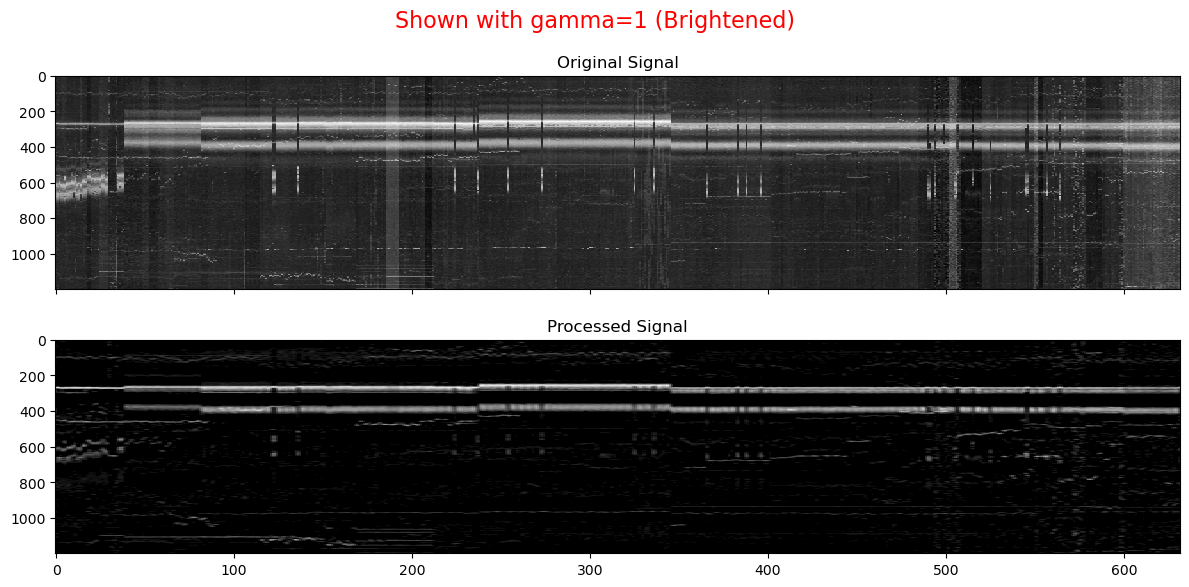

In [10]:
qid = 10
gamma = 1

denoised2d_signals={}; key=f"Q{qid}_s(freq, t)"
denoised2d_signals[key] = remove_high_freq_noise_2d(denoised_signals[key], radius=150)
compare_plot(
    reverted_normalized[f"Q{qid}_s(freq, t)"] ** gamma,
    denoised2d_signals[f"Q{qid}_s(freq, t)"] ** gamma,
    title=f"Shown with gamma={gamma} (Brightened)",
    title_color='red',
)

### 3.3. <a id='toc3_3_'></a>[Flatten peaks](#toc0_)

In [12]:
import numpy as np
from scipy.signal import find_peaks

def flatten_columnwise_peaks_rmean(
    img: np.ndarray,
    prominence: float = 0.05,
    min_width: float = 1.0,
    rel_height: float = 0.5,
    r: float = 2.0,
    **peak_args: Any
) -> np.ndarray:
    """
    Flatten Gaussian-like peaks per column using r-power mean inside each peak region.
    Outside all peaks, values are set to 0.

    Parameters:
        img:         2D input array (freqs x time)
        prominence:  Minimum prominence for peak detection
        min_width:   Minimum peak width (in pixels)
        rel_height:  Height level for width estimation (0.5 = FWHM)
        r:           Power for generalized mean:
                     r > 0 → power mean
                     r = 0 → geometric mean
                     r = +inf → max
                     r = -inf → min

    Returns:
        2D array with flattened peak regions using r-mean
    """
    H, W = img.shape
    output = np.zeros_like(img)

    def flatten_region_with_rmean(region: np.ndarray, r: float) -> None:
        if np.isposinf(r):
            mean_val = np.max(region)
        elif np.isneginf(r):
            mean_val = np.min(region)
        elif r == 0:
            mean_val = np.exp(np.mean(np.log(region + 1e-12)))
        else:
            mean_val = (np.sum(region ** r) / len(region)) ** (1.0 / r)

        output[l:r_idx, j] = mean_val
        return

    for j in range(W):
        col = img[:, j]

        peaks, properties = find_peaks(
            col,
            prominence=prominence,
            width=min_width,
            rel_height=rel_height
        )

        if len(peaks) > 0:

            left = np.floor(properties['left_ips']).astype(int)
            right = np.ceil(properties['right_ips']).astype(int)

            for l, r_idx in zip(left, right):
                # for each peak region
                l = max(0, l)
                r_idx = min(H, r_idx)
                region = col[l:r_idx]

                if region.size != 0:
                    flatten_region_with_rmean(region, r)

    return output

In [ ]:
qid = 10
signal = denoised_signals[f"Q{qid}_s(freq, t)"].copy()  # shape: (1200, N)
signal[signal < 1e-2] = 0

from scipy.ndimage import gaussian_filter
# smoothed = gaussian_filter(signal, sigma=2.0)
# smoothed = gaussian_filter(smoothed, sigma=(0.0, 4.0))  # only horizontal

r_mean = 1.0  # Power for generalized mean
flattened = flatten_columnwise_peaks_rmean(
    signal,
    prominence=0.05,
    distance=0,
    min_width=2,
    rel_height=1.0,
    r=r_mean,
)

compare_plot(
    signal,# ** 0.5,
    flattened,# > 1e-18,
    # aspect=1.0,
    title=f"Flattened Signal for Q{qid} (r={r_mean})"
)

### 3.4. <a id='toc3_4_'></a>[Keep only horizontal >= 3](#toc0_)

In [ ]:
import numpy as np

def filter_by_horizontal_similarity(signal: np.ndarray, similar_tol: float = 0.1, mode='max') -> np.ndarray:
    """
    Keep only pixels whose left or right 2 neighbors + self form a sequence
    of 3 similar values (relative difference within `tol`).
    
    signal: 2D array (freqs, time), normalized to [0, 1]
    tol: relative tolerance (e.g., 0.1 means 10% difference allowed)
    
    Returns:
        A masked signal where only consistent triplets are retained.
    """
    padded = np.pad(signal, ((0, 0), (2, 2)), mode='edge')  # pad time axis

    center = padded[:, 2:-2]
    left1  = padded[:, 1:-3]
    left2  = padded[:, 0:-4]
    right1 = padded[:, 3:-1]
    right2 = padded[:, 4:]

    if mode == 'nonzero':
        left_triplet = (left2 > 0) & (left1 > 0) & (center > 0)
        right_triplet = (center > 0) & (right1 > 0) & (right2 > 0)
        mask = left_triplet | right_triplet
        return (mask * signal).astype(signal.dtype)
    
    if mode == 'max':
        def similar(a, b):
            max_ab = np.maximum(np.abs(a), np.abs(b)) + 1e-12
            return np.abs(a - b) <= similar_tol * max_ab
    elif mode == 'min':
        def similar(a, b):
            min_ab = np.minimum(np.abs(a), np.abs(b)) + 1e-12
            return np.abs(a - b) <= similar_tol * min_ab
    else:
        raise Exception('`mode` only supports "max" or "min"')

    # Check left triplet: left2 ~ left1 ~ center
    left_triplet = (
        similar(left2, left1) & 
        similar(left1, center) & 
        similar(left2, center)
    )

    # Check right triplet: center ~ right1 ~ right2
    right_triplet = (
        similar(center, right1) & 
        similar(right1, right2) & 
        similar(center, right2)
    )

    mask = left_triplet | right_triplet
    return (mask * signal).astype(signal.dtype)


In [ ]:
qid = 10

horifiltered = filter_by_horizontal_similarity(signal, similar_tol=1, mode='nonzero')

compare_plot(
    signal > 0,
    horifiltered > 0,
    aspect=0.1
)

In [ ]:
from scipy.ndimage import gaussian_filter
# smoothed = gaussian_filter(signal, sigma=2.0)
# smoothed = gaussian_filter(smoothed, sigma=(0.0, 4.0))  # only horizontal

r_mean = 1.0  # Power for generalized mean
flattened_hori = flatten_columnwise_peaks_rmean(
    horifiltered,
    prominence=0.01,
    distance=0,
    min_width=2,
    rel_height=1.0,
    r=r_mean,
)

compare_plot(
    reverted_normalized[f'Q{qid}_s(freq, t)'] ** 0.5,
    flattened_hori > 1e-18,
    # aspect=1.0,
    title=f"Flattened Signal for Q{qid} (r={r_mean})"
)

### 3.5. <a id='toc3_5_'></a>[Filter by connected component size](#toc0_)

In [85]:
def filter_connected_size(mask: np.ndarray, min_width=10, min_height=5, progress_bar=True):
    mask = (mask * 255).astype(np.int8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=4)
    filtered = np.zeros_like(mask)
    for i in tqdm(range(1, num_labels), disable=not progress_bar):
        x, y, w, h, _ = stats[i]
        if w >= min_width and h >= min_height:
            filtered[labels == i] = mask[labels == i]
    return filtered

In [83]:
connect_filtered = filter_connected_size(flattened_hori, min_width=15, min_height=1)

compare_plot(
    # flattened_hori,
    reverted_normalized[f'Q{qid}_s(freq, t)'] ** 0.5,
    connect_filtered,
)

100%|██████████| 1921/1921 [00:00<00:00, 29941.39it/s]


### 3.6. <a id='toc3_6_'></a>[All steps together](#toc0_)

In [113]:
processed_signals = {}
for key, signal in tqdm(reverted_normalized.items(), desc="Denoising signals"):
    assert type(signal) is np.ndarray
    denoised = denoise(signal, low_rel=0.005, high_rel=0.10)
    denoised[denoised < 1e-2] = 0
    horifiltered = filter_by_horizontal_similarity(denoised, similar_tol=1, mode='nonzero')
    r_mean = 1.0  # Power for generalized mean
    flattened_hori = flatten_columnwise_peaks_rmean(
        horifiltered,
        prominence=0.01,
        distance=0,
        min_width=2,
        rel_height=1.0,
        r=r_mean,
    )
    connect_filtered = filter_connected_size(flattened_hori, min_width=15, min_height=1, progress_bar=False)
    processed_signals[key] = connect_filtered

Denoising signals: 100%|██████████| 72/72 [00:30<00:00,  2.33it/s]


In [121]:
processed_path = 'TLS_DATA/processed.npz'
for k, v in reverted_normalized.items():
    if k not in processed_signals:
        processed_signals[k] = v
np.savez_compressed(processed_path, **processed_signals)

In [ ]:
import numpy as np
import cv2

def overlay_mask_on_image(
    image: np.ndarray,
    mask: np.ndarray,
    boundary_thick: int = 1,
    color_mode: str = 'color',
    mode: str = 'boundary',  # 'boundary' or 'stack'
    alpha: float = 0.3
) -> np.ndarray:
    if color_mode == 'gray' and image.ndim == 2:
        overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        overlay = image.copy()

    if color_mode == 'color' and overlay.shape[2] == 3:
        overlay = overlay[..., ::-1].copy()  # convert RGB to BGR

    if mode == 'boundary':
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cv2.drawContours(overlay, contours, -1, (0, 0, 255), thickness=boundary_thick)

    elif mode == 'stack':
        red_layer = np.zeros_like(overlay, dtype=np.uint8)
        red_layer[mask > 0] = (0, 0, 255)
        overlay = cv2.addWeighted(overlay, 1.0, red_layer, alpha, 0)

    else:
        raise ValueError("mode must be either 'boundary' or 'stack'")

    return overlay[..., ::-1]  # convert BGR back to RGB if needed

In [119]:
output_dir = 'TLS_DATA/overlays'
os.makedirs(output_dir, exist_ok=True)

for key, signal in tqdm(processed_signals.items()):
    overlayed = overlay_mask_on_image(
        (reverted_normalized[key] * 255).astype(np.uint8),
        (signal > 0).astype(np.uint8),
        color_mode='gray',
        boundary_thick=2,
        alpha=0.2,
        mode='stack',
    )
    overlayed_repeated = np.repeat(overlayed, repeats=10, axis=1)
    bgr = overlayed_repeated[..., ::-1]  # Convert RGB to BGR for OpenCV

    filename = os.path.join(output_dir, f"{key}.png")
    cv2.imwrite(filename, bgr)

100%|██████████| 72/72 [00:27<00:00,  2.61it/s]


### 3.7. <a id='toc3_7_'></a>[Find edges and fill](#toc0_)

In [194]:
def compute_edge_strength(img, sobel_ksize=3, blur_ksize=0):
    if blur_ksize >= 3:
        img = cv2.GaussianBlur(img, (blur_ksize, blur_ksize), 0)
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=sobel_ksize)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=sobel_ksize)
    edge = np.sqrt(grad_x**2 + grad_y**2)
    return edge


def find_and_fill_contours(img, edge, edge_thresh=0.2):
    edge_mask = (edge > edge_thresh).astype(np.uint8)
    contours, _ = cv2.findContours(edge_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_img = np.zeros_like(img, dtype=np.float32)

    for cnt in tqdm(contours):
        mask = np.zeros_like(img, dtype=np.uint8).copy()

        cv2.drawContours(mask, [cnt], -1, color=1, thickness=-1) # type: ignore

        edge_strength = edge[mask.astype(bool)].mean()
        filled_img[mask == 1] = edge_strength

    return filled_img

In [201]:
qid = 10
signal = denoised_signals[f"Q{qid}_s(freq, t)"].astype(np.float32)

edges = []
scales = [3, 5, ]
for s in scales:
    edges.append(compute_edge_strength(signal, sobel_ksize=s))

combined = np.maximum.reduce(edges)



filled = find_and_fill_contours(
    img=signal,
    edge=combined,
    edge_thresh=0.8,
)

compare_plot(
    denoised_signals[f"Q{qid}_s(freq, t)"],
    filled,
)

100%|██████████| 2718/2718 [00:03<00:00, 835.08it/s]


In [191]:
scales = [1, 2, 4]
edges = []
for s in scales:
    blurred = cv2.GaussianBlur(signal, (0, 0), sigmaX=s)
    edge = cv2.Laplacian(blurred, cv2.CV_32F)
    edges.append(np.abs(edge))

combined = np.maximum.reduce(edges)

filled = find_and_fill_contours(
    img=signal,
    edge=combined,
    edge_thresh=0.005,
)

compare_plot(
    denoised_signals[f"Q{qid}_s(freq, t)"],
    filled,
)

100%|██████████| 5969/5969 [00:06<00:00, 867.43it/s]
